# Tutorial: Train SimCLR on Clothing

# Imports

In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pytorch_lightning as pl
import torch
import torch.nn as nn
import torchvision
from PIL import Image
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import normalize

from lightly.data import LightlyDataset
from lightly.transforms import SimCLRTransform, utils

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-url1_ea0 because the default path (/home/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


# Configuration

We set some configuration parameters for our experiment. Feel free to change them and analyze the effect.

The default configuration with a batch size of 256 and input resolution of 128 requires 6GB of GPU memory.

In [2]:
num_workers = 8
batch_size = 64
seed = 1
max_epochs = 1
input_size = 128
num_ftrs = 32

Let’s set the seed for our experiments

In [3]:
pl.seed_everything(seed)

Global seed set to 1


1

# Setup data augmentations and loaders

In [4]:
# path_to_data = "/data/clothing-dataset-small/train"
path_to_data = "/data/clothing-dataset-small/train"
# path_to_train_data = "/data/clothing-dataset-small/train"
# path_to_val_data =  "/data/clothing-dataset-small/validation"
# path_to_test_data = "/data/clothing-dataset-small/test"

The images from the dataset have been taken from above when the clothing was on a table, bed or floor. Therefore, we can make use of additional augmentations such as vertical flip or random rotation (90 degrees). By adding these augmentations we learn our model invariance regarding the orientation of the clothing piece. E.g. we don’t care if a shirt is upside down but more about the strcture which make it a shirt.

In [5]:
transform = SimCLRTransform(input_size=input_size, vf_prob=0.5, rr_prob=0.5)

# We create a torchvision transformation for embedding the dataset after
# training
test_transform = torchvision.transforms.Compose(
    [
        torchvision.transforms.Resize((input_size, input_size)),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(
            mean=utils.IMAGENET_NORMALIZE["mean"],
            std=utils.IMAGENET_NORMALIZE["std"],
        ),
    ]
)

dataset_train_simclr = LightlyDataset(input_dir=path_to_data, transform=transform)

dataset_test = LightlyDataset(input_dir=path_to_data, transform=test_transform)

dataloader_train_simclr = torch.utils.data.DataLoader(
    dataset_train_simclr,
    batch_size=batch_size,
    shuffle=True,
    drop_last=True,
    num_workers=num_workers,
)

dataloader_test = torch.utils.data.DataLoader(
    dataset_test,
    batch_size=batch_size,
    shuffle=False,
    drop_last=False,
    num_workers=num_workers,
)

# Create the SimCLR Model

Now we create the SimCLR model. We implement it as a PyTorch Lightning Module and use a MobilenetV2 backbone from Torchvision. Lightly provides implementations of the SimCLR projection head and loss function in the SimCLRProjectionHead and NTXentLoss classes. We can simply import them and combine the building blocks in the module.

In [6]:
from lightly.loss import NTXentLoss
from lightly.models.modules.heads import SimCLRProjectionHead


class SimCLRModel(pl.LightningModule):
    def __init__(self, num_ftrs=512):
        super().__init__()

        # create a Mobilenet_v2 backbone and remove the classification head
        mobilenet_v2 = torchvision.models.mobilenet_v2()
        self.backbone = nn.Sequential(
            *list(mobilenet_v2.children())[:-1],
            nn.AdaptiveAvgPool2d(output_size=(1,1)),
            nn.Flatten(),
            nn.Linear(1280, num_ftrs, bias=False)
            )

        self.projection_head = SimCLRProjectionHead(num_ftrs, num_ftrs, 128)

        self.criterion = NTXentLoss()

    def forward(self, x):
        h = self.backbone(x).flatten(start_dim=1)
        z = self.projection_head(h)
        return z

    def training_step(self, batch, batch_idx):
        (x0, x1), _, _ = batch
        z0 = self.forward(x0)
        z1 = self.forward(x1)
        loss = self.criterion(z0, z1)
        self.log("train_loss_ssl", loss)
        return loss

    def configure_optimizers(self):
        optim = torch.optim.SGD(
            self.parameters(), lr=6e-2, momentum=0.9, weight_decay=5e-4
        )
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optim, max_epochs)
        return [optim], [scheduler]

Train the module using the PyTorch Lightning Trainer on a single GPU.

In [7]:
model = SimCLRModel(num_ftrs=num_ftrs)
trainer = pl.Trainer(max_epochs=max_epochs,
                     devices=1,
                     accelerator="gpu",
                     )
trainer.fit(model, dataloader_train_simclr)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type                 | Params
---------------------------------------------------------
0 | backbone        | Sequential           | 2.3 M 
1 | projection_head | SimCLRProjectionHead | 5.4 K 
2 | criterion       | NTXentLoss           | 0     
---------------------------------------------------------
2.3 M     Trainable params
0         Non-trainable params
2.3 M     Total params
9.081     Total estimated model params size (MB)
/usr/local/lib/python3.9/dist-packages/pytorch_lightning/loops/fit_loop.py:280: PossibleUserWarning: The number of training batches (47) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Epoch 0: 100%|██████████| 47/47 [00:18<00:00,  2.61it/s, v_num=12]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 47/47 [00:18<00:00,  2.58it/s, v_num=12]


Next we create a helper function to generate embeddings from our test images using the model we just trained. Note that only the backbone is needed to generate embeddings, the projection head is only required for the training. Make sure to put the model into eval mode for this part!

In [8]:
def generate_embeddings(model, dataloader):
    """Generates representations for all images in the dataloader with
    the given model
    """

    embeddings = []
    filenames = []
    with torch.no_grad():
        for img, _, fnames in dataloader:
            # print(img.shape)
            try:
                img = img.to(model.device)
                # print(img[0,0,0,0])
                emb = model.backbone(img).flatten(start_dim=1)
                # print(emb[:5])
                embeddings.append(emb)
                filenames.extend(fnames)
            except:
                continue

    embeddings = torch.cat(embeddings, 0)
    embeddings = normalize(embeddings)
    return embeddings, filenames


model.eval()
embeddings, filenames = generate_embeddings(model, dataloader_test)

# Visualize Nearest Neighbors

Let’s look at the trained embedding and visualize the nearest neighbors for a few random samples.

We create some helper functions to simplify the work

In [9]:
def get_image_as_np_array(filename: str):
    """Returns an image as an numpy array"""
    img = Image.open(filename)
    return np.asarray(img)

def plot_knn_examples(embeddings, filenames, n_neighbors=3, num_examples=6):
    """Plots multiple rows of random images with their nearest neighbors"""
    # lets look at the nearest neighbors for some samples
    # we use the sklearn library
    nbrs = NearestNeighbors(n_neighbors=n_neighbors).fit(embeddings)
    distances, indices = nbrs.kneighbors(embeddings)

    # get 5 random samples
    samples_idx = np.random.choice(len(indices), size=num_examples, replace=False)

    # loop through our randomly picked samples
    for idx in samples_idx:
        fig = plt.figure()
        # loop through their nearest neighbors
        for plot_x_offset, neighbor_idx in enumerate(indices[idx]):
            # add the subplot
            ax = fig.add_subplot(1, len(indices[idx]), plot_x_offset + 1)
            # get the correponding filename for the current index
            fname = os.path.join(path_to_data, filenames[neighbor_idx])
            # plot the image
            plt.imshow(get_image_as_np_array(fname))
            # set the title to the distance of the neighbor
            ax.set_title(f"d={distances[idx][plot_x_offset]:.3f}")
            # let's disable the axis
            plt.axis("off")

Let’s do the plot of the images. The leftmost image is the query image whereas the ones next to it on the same row are the nearest neighbors. In the title we see the distance of the neigbor

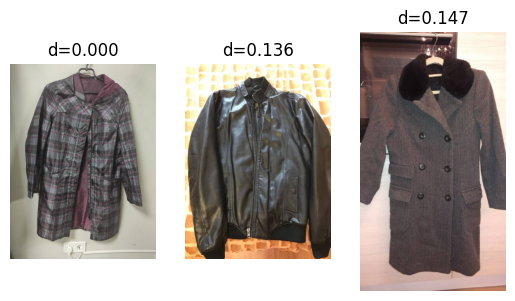

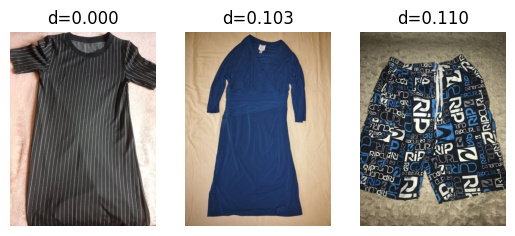

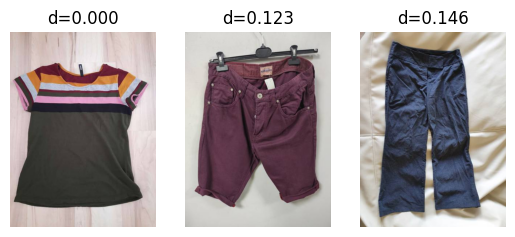

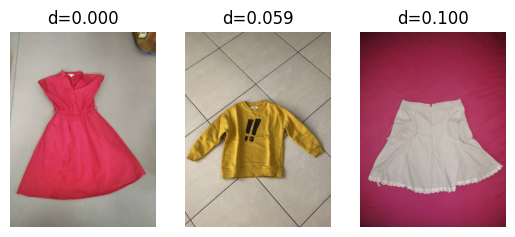

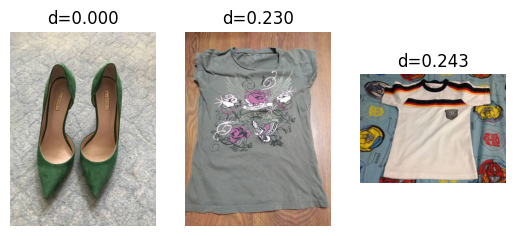

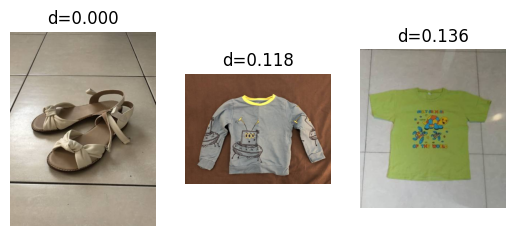

In [10]:
plot_knn_examples(embeddings, filenames)

# Color Invariance

Let’s train again without color augmentation. This will force our model to respect the colors in the images.

In [11]:
# Set color jitter and gray scale probability to 0
new_transform = SimCLRTransform(
    input_size=input_size, vf_prob=0.5, rr_prob=0.5, cj_prob=0.0, random_gray_scale=0.0
)

# let's update the transform on the training dataset
dataset_train_simclr.transform = new_transform

# then train a new model
model = SimCLRModel(num_ftrs=num_ftrs)
trainer = pl.Trainer(max_epochs=max_epochs, devices=1, accelerator="gpu")
trainer.fit(model, dataloader_train_simclr)

# and generate again embeddings from the test set
model.eval()
embeddings, filenames = generate_embeddings(model, dataloader_test)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type                 | Params
---------------------------------------------------------
0 | backbone        | Sequential           | 2.3 M 
1 | projection_head | SimCLRProjectionHead | 5.4 K 
2 | criterion       | NTXentLoss           | 0     
---------------------------------------------------------
2.3 M     Trainable params
0         Non-trainable params
2.3 M     Total params
9.081     Total estimated model params size (MB)
/usr/local/lib/python3.9/dist-packages/pytorch_lightning/loops/fit_loop.py:280: PossibleUserWarning: The number of training batches (47) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Epoch 0: 100%|██████████| 47/47 [00:17<00:00,  2.75it/s, v_num=13]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 47/47 [00:17<00:00,  2.71it/s, v_num=13]


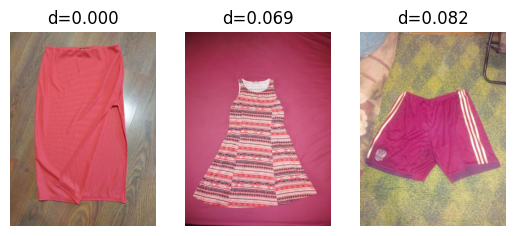

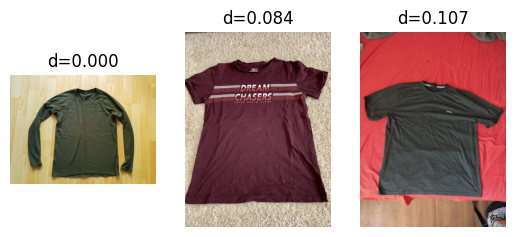

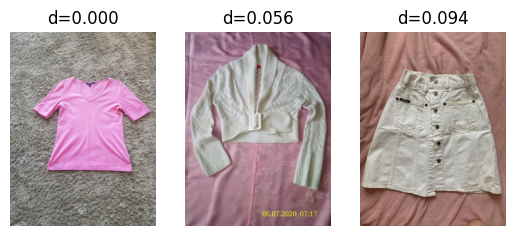

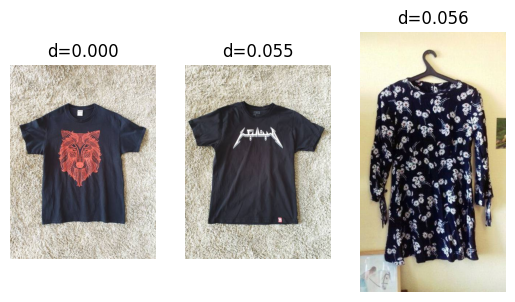

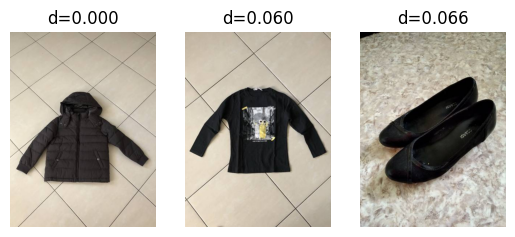

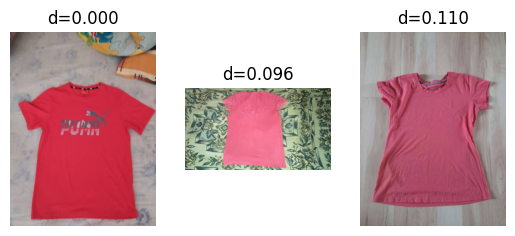

In [12]:
plot_knn_examples(embeddings, filenames)

What’s next?

In [13]:
# You could use the pre-trained model and train a classifier on top.
pretrained_mobilenet_backbone = model.backbone

# you can also store the backbone and use it in another code
state_dict = {"mobilenetv2_parameters": pretrained_mobilenet_backbone.state_dict()}
torch.save(state_dict, "/workspace/weights/mobilenetv2_parameters-SimCLR-clothing.pth")

In [14]:
list(pretrained_mobilenet_backbone.children())[-1]

Linear(in_features=1280, out_features=32, bias=False)

In [15]:
# load the model in a new file for inference

mobilenet_v2 = torchvision.models.mobilenet_v2()
backbone_loaded = nn.Sequential(
    *list(mobilenet_v2.children())[:-1],
    nn.AdaptiveAvgPool2d(output_size=(1,1)),
    nn.Flatten(),
    nn.Linear(1280, num_ftrs, bias=False)
    )

ckpt = torch.load("/workspace/weights/mobilenetv2_parameters-SimCLR-clothing.pth")
backbone_loaded.load_state_dict(ckpt["mobilenetv2_parameters"])

<All keys matched successfully>

In [16]:
list(backbone_loaded.children())[-1]

Linear(in_features=1280, out_features=32, bias=False)